In [35]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('./gan-getting-started'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./gan-getting-started/photo_jpg/5a384bf8d9.jpg
./gan-getting-started/photo_jpg/bb15fcc4ff.jpg
./gan-getting-started/photo_jpg/39c1270676.jpg
./gan-getting-started/photo_jpg/506fdcb3c1.jpg
./gan-getting-started/photo_jpg/63f6cea734.jpg
./gan-getting-started/photo_jpg/7b95afc20a.jpg
./gan-getting-started/photo_jpg/0723d52098.jpg
./gan-getting-started/photo_jpg/3be1aea5fc.jpg
./gan-getting-started/photo_jpg/114692dc5b.jpg
./gan-getting-started/photo_jpg/d665568cdf.jpg
./gan-getting-started/photo_jpg/ada64f6f98.jpg
./gan-getting-started/photo_jpg/7a317ade8c.jpg
./gan-getting-started/photo_jpg/9c92f8345f.jpg
./gan-getting-started/photo_jpg/f40b429650.jpg
./gan-getting-started/photo_jpg/f298108b32.jpg
./gan-getting-started/photo_jpg/6f8cb591c0.jpg
./gan-getting-started/photo_jpg/8f9cc89fc1.jpg
./gan-getting-started/photo_jpg/9079fe9d9c.jpg
./gan-getting-started/photo_jpg/f6798eb074.jpg
./gan-getting-started/photo_jpg/9588a52282.jpg
./gan-getting-started/photo_jpg/0cdfbb28e6.jpg
./gan-getting

In [2]:
import os, random, json, PIL, shutil, re , glob
import numpy as np

import cv2
import pandas as pd
import seaborn as sns
from PIL import ImageDraw
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras import Model, losses, optimizers
from tensorflow.keras.callbacks import Callback
import math
AUTOTUNE = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.MirroredStrategy()


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


/Users/home/anaconda3/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
EPOCHS = 50
BATCH_SIZE = 1

## Dataset

In [4]:
IMAGE_SIZE = [256, 256]
def count_data_files(names):
    n = [int(re.compile(r"-([0-9]*)\.").search(name).group(1)) for name in names]
    return np.sum(n)
def get_normalized(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = get_normalized(example['image'])
    return image
    
def load_dataset(files, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(files)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [5]:
path = "./gan-getting-started"
monet_files = tf.io.gfile.glob(str( path + '/monet_tfrec/*.tfrec'))
photo_files = tf.io.gfile.glob(str(path + '/photo_tfrec/*.tfrec'))
monet_images = load_dataset(monet_files, labeled=True).batch(1)
photo_images = load_dataset(photo_files, labeled=True).batch(1)

## Visualization

In [7]:
def visualize_images(ds, title, samples=5):
    num_cols = min(samples, 5)
    num_rows = (samples + num_cols - 1) // num_cols
    plt.figure(figsize=(4*num_cols, 4*num_rows))
    for i, img in enumerate(ds.take(samples)):
        plt.subplot(num_rows, num_cols, i+1)
        plt.title(f'{title} {i+1}')
        plt.imshow(img[0] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()


In [ ]:
visualize_images(monet_images,'Monet',10)

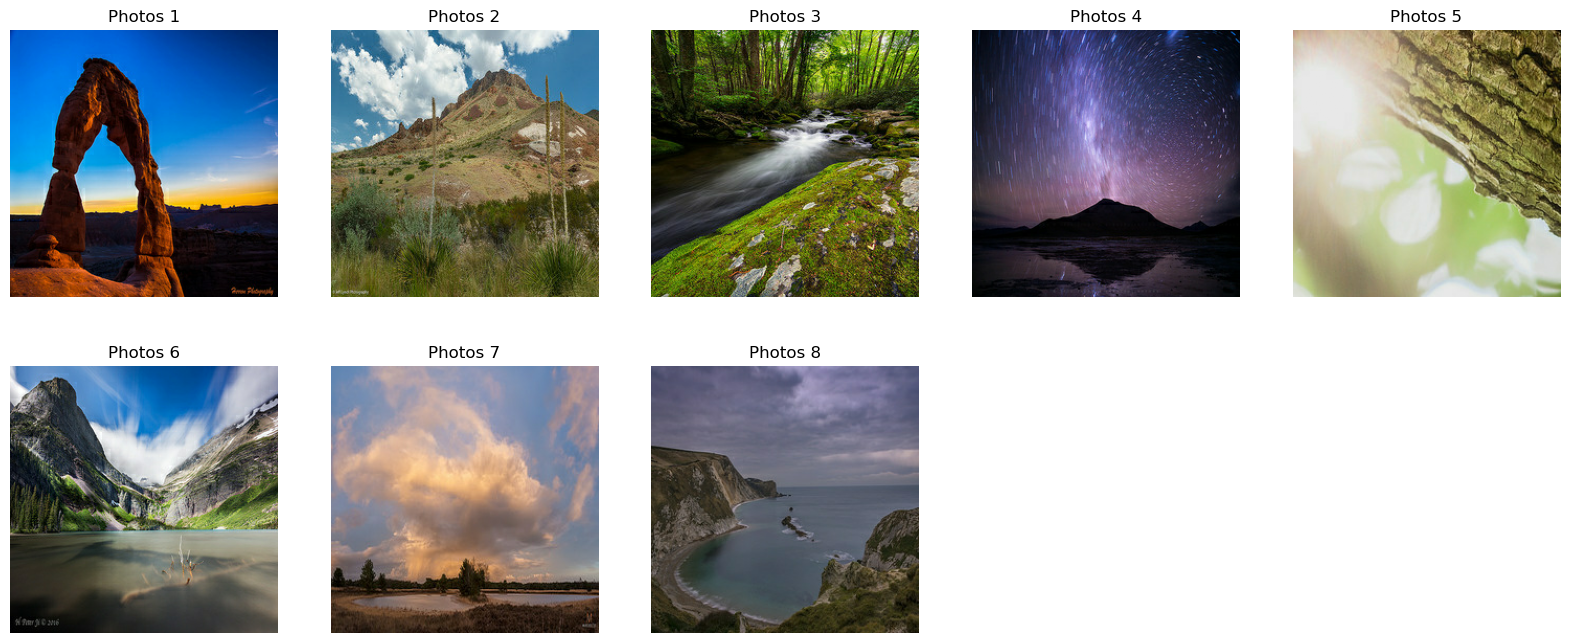

In [9]:
visualize_images(photo_images,'Photos',8)

## Generator

In [10]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [11]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

## Discriminator

In [12]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [13]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,  kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [14]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

## CycleGan

In [15]:
class CycleGan(keras.Model):
    def __init__(
        self,monet_generator,photo_generator,monet_discriminator,photo_discriminator,lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(self,m_gen_optimizer,p_gen_optimizer,m_disc_optimizer,p_disc_optimizer,gen_loss_fn,disc_loss_fn,cycle_loss_fn, identity_loss_fn ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [16]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos


## Discriminator Loss

In [17]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

## Generator Loss

In [18]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

## Cycle Loss

In [19]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

## Identitiy Loss

In [20]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss


## Training the Model

In [21]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)

In [22]:
with strategy.scope():
    cycle_gan_model = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [23]:
hist=cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_images, photo_images)),
    epochs=30
)

Epoch 1/30


2023-12-18 23:13:43.090156: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 613s 2s/step - monet_gen_loss: 5.0957 - photo_gen_loss: 5.1924 - monet_disc_loss: 0.6338 - photo_disc_loss: 0.6441
Epoch 2/30


2023-12-18 23:23:56.063768: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 580s 2s/step - monet_gen_loss: 3.6322 - photo_gen_loss: 3.7422 - monet_disc_loss: 0.6642 - photo_disc_loss: 0.6112
Epoch 3/30


2023-12-18 23:33:36.790243: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 561s 2s/step - monet_gen_loss: 3.6049 - photo_gen_loss: 3.7085 - monet_disc_loss: 0.6359 - photo_disc_loss: 0.6144
Epoch 4/30


2023-12-18 23:42:57.632644: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 573s 2s/step - monet_gen_loss: 3.4993 - photo_gen_loss: 3.6245 - monet_disc_loss: 0.6396 - photo_disc_loss: 0.6061
Epoch 5/30


2023-12-18 23:52:30.297531: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 568s 2s/step - monet_gen_loss: 3.3363 - photo_gen_loss: 3.4952 - monet_disc_loss: 0.6377 - photo_disc_loss: 0.5995
Epoch 6/30


2023-12-19 00:01:58.806421: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 584s 2s/step - monet_gen_loss: 3.2605 - photo_gen_loss: 3.4059 - monet_disc_loss: 0.6232 - photo_disc_loss: 0.5935
Epoch 7/30


2023-12-19 00:11:42.456200: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 593s 2s/step - monet_gen_loss: 3.1918 - photo_gen_loss: 3.2904 - monet_disc_loss: 0.6142 - photo_disc_loss: 0.6053
Epoch 8/30


2023-12-19 00:21:35.470312: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 599s 2s/step - monet_gen_loss: 3.1561 - photo_gen_loss: 3.2254 - monet_disc_loss: 0.6129 - photo_disc_loss: 0.6078
Epoch 9/30


2023-12-19 00:31:34.372161: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 605s 2s/step - monet_gen_loss: 3.1336 - photo_gen_loss: 3.1793 - monet_disc_loss: 0.6098 - photo_disc_loss: 0.6101
Epoch 10/30


2023-12-19 00:41:39.211107: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 565s 2s/step - monet_gen_loss: 3.1071 - photo_gen_loss: 3.1265 - monet_disc_loss: 0.6005 - photo_disc_loss: 0.6086
Epoch 11/30


2023-12-19 00:51:04.078582: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 602s 2s/step - monet_gen_loss: 3.0773 - photo_gen_loss: 3.0915 - monet_disc_loss: 0.6007 - photo_disc_loss: 0.6078
Epoch 12/30


2023-12-19 01:01:06.586126: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 554s 2s/step - monet_gen_loss: 3.0431 - photo_gen_loss: 3.0505 - monet_disc_loss: 0.6007 - photo_disc_loss: 0.6095
Epoch 13/30


2023-12-19 01:10:20.819664: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 584s 2s/step - monet_gen_loss: 3.0146 - photo_gen_loss: 3.0096 - monet_disc_loss: 0.6022 - photo_disc_loss: 0.6109
Epoch 14/30


2023-12-19 01:20:05.313262: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 563s 2s/step - monet_gen_loss: 2.9922 - photo_gen_loss: 2.9782 - monet_disc_loss: 0.5983 - photo_disc_loss: 0.6111
Epoch 15/30


2023-12-19 01:29:28.713635: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 561s 2s/step - monet_gen_loss: 2.9745 - photo_gen_loss: 2.9488 - monet_disc_loss: 0.5973 - photo_disc_loss: 0.6143
Epoch 16/30


2023-12-19 01:38:49.531464: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 558s 2s/step - monet_gen_loss: 2.9540 - photo_gen_loss: 2.9319 - monet_disc_loss: 0.6033 - photo_disc_loss: 0.6165
Epoch 17/30


2023-12-19 01:48:07.151556: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 558s 2s/step - monet_gen_loss: 2.9106 - photo_gen_loss: 2.9134 - monet_disc_loss: 0.6125 - photo_disc_loss: 0.6142
Epoch 18/30


2023-12-19 01:57:25.417487: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 556s 2s/step - monet_gen_loss: 2.8686 - photo_gen_loss: 2.8964 - monet_disc_loss: 0.6170 - photo_disc_loss: 0.6083
Epoch 19/30


2023-12-19 02:06:41.324034: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 556s 2s/step - monet_gen_loss: 2.8450 - photo_gen_loss: 2.8712 - monet_disc_loss: 0.6204 - photo_disc_loss: 0.6135
Epoch 20/30


2023-12-19 02:15:57.239249: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 560s 2s/step - monet_gen_loss: 2.8319 - photo_gen_loss: 2.8487 - monet_disc_loss: 0.6167 - photo_disc_loss: 0.6110
Epoch 21/30


2023-12-19 02:25:17.232633: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 589s 2s/step - monet_gen_loss: 2.7840 - photo_gen_loss: 2.8144 - monet_disc_loss: 0.6176 - photo_disc_loss: 0.6084
Epoch 22/30


2023-12-19 02:35:05.948743: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 599s 2s/step - monet_gen_loss: 2.7715 - photo_gen_loss: 2.7895 - monet_disc_loss: 0.6215 - photo_disc_loss: 0.6200
Epoch 23/30


2023-12-19 02:45:05.050011: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 565s 2s/step - monet_gen_loss: 2.7844 - photo_gen_loss: 2.7979 - monet_disc_loss: 0.6176 - photo_disc_loss: 0.6154
Epoch 24/30


2023-12-19 02:54:29.972539: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 565s 2s/step - monet_gen_loss: 2.7194 - photo_gen_loss: 2.7448 - monet_disc_loss: 0.6270 - photo_disc_loss: 0.6246
Epoch 25/30


2023-12-19 03:03:55.476032: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 553s 2s/step - monet_gen_loss: 2.8325 - photo_gen_loss: 2.8557 - monet_disc_loss: 0.5972 - photo_disc_loss: 0.5909
Epoch 26/30


2023-12-19 03:13:09.036088: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 557s 2s/step - monet_gen_loss: 2.7295 - photo_gen_loss: 2.7876 - monet_disc_loss: 0.6190 - photo_disc_loss: 0.6021
Epoch 27/30


2023-12-19 03:22:25.781464: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 553s 2s/step - monet_gen_loss: 2.7032 - photo_gen_loss: 2.7641 - monet_disc_loss: 0.6198 - photo_disc_loss: 0.6130
Epoch 28/30


2023-12-19 03:31:39.026409: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 558s 2s/step - monet_gen_loss: 2.7437 - photo_gen_loss: 2.7742 - monet_disc_loss: 0.6036 - photo_disc_loss: 0.6081
Epoch 29/30


2023-12-19 03:40:57.240903: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 561s 2s/step - monet_gen_loss: 2.9113 - photo_gen_loss: 2.8750 - monet_disc_loss: 0.5608 - photo_disc_loss: 0.5653
Epoch 30/30


2023-12-19 03:50:18.692192: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


300/300 [==============================] - 559s 2s/step - monet_gen_loss: 2.8619 - photo_gen_loss: 2.8618 - monet_disc_loss: 0.6061 - photo_disc_loss: 0.6090


## Visualize Monet Photos

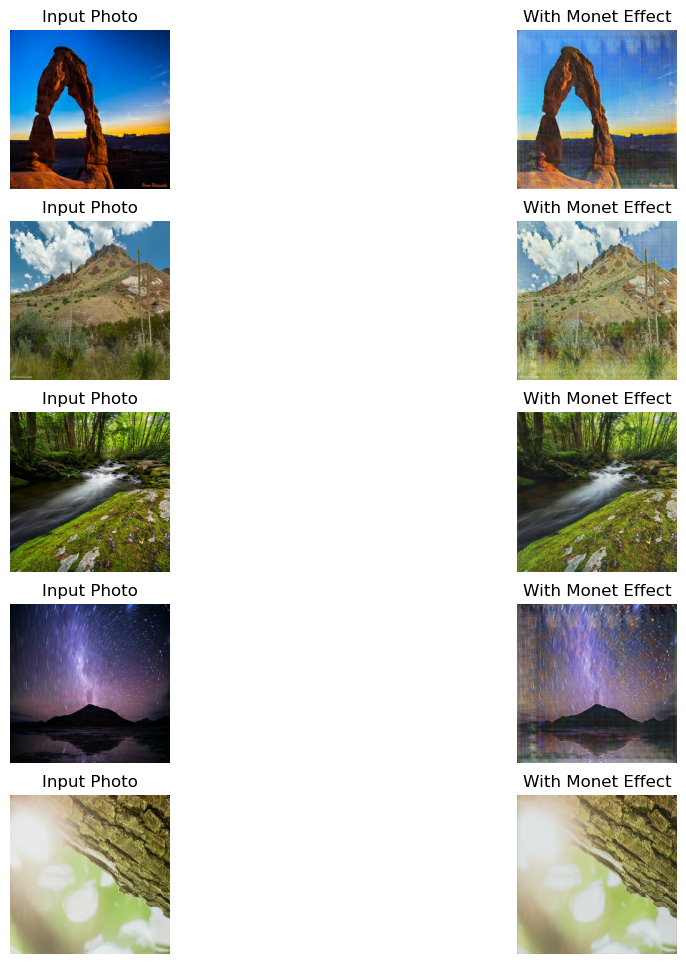

In [40]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_images.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("With Monet Effect")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


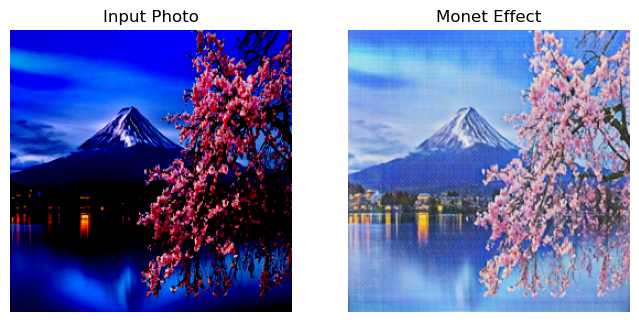

In [41]:
import requests
from io import BytesIO
from PIL import Image

# Download and resize the image
response = requests.get("https://media.istockphoto.com/id/1137578281/photo/fuji-mountain-and-cherry-blossoms-in-spring-japan.jpg?s=612x612&w=0&k=20&c=H4T0916_yYJTjeKAaaLmYoQY3OMmaFShks6RfpYYVf4=")
img = Image.open(BytesIO(response.content))
img = img.resize((256, 256))

# Convert the image to a numpy array and normalize
img = np.array(img)
img = (img / 127.5) - 1

# Generate the Monet version
prediction = monet_generator(np.expand_dims(img, axis=0), training=False)[0].numpy()
prediction = (prediction * 127.5 + 127.5).astype(np.uint8)

# Display the input and output images
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img)
ax[1].imshow(prediction)
ax[0].set_title("Input Photo")
ax[1].set_title("Monet Effect")
ax[0].axis("off")
ax[1].axis("off")
plt.show()
